# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

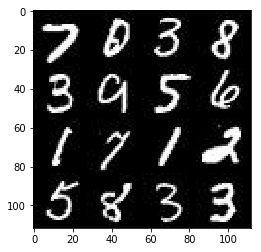

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

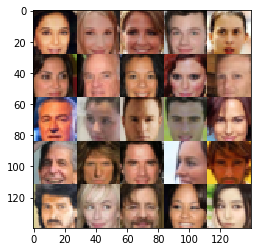

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input 28x28x3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2,  training=True)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3,  training=True)
        conv3 = tf.maximum(alpha * conv3, conv3)

        flat  = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 7x7x512
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding="same")
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x256
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides=2, padding="same")
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=2, padding="same")
        out = tf.tanh(logits)
    
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate_, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 80
    
    _, image_width, image_height, image_channels = data_shape
    inputs_real, inputs_z, learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                                
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict={learning_rate: learning_rate_, inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={learning_rate: learning_rate_, inputs_real: batch_images, inputs_z: batch_z})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_real: batch_images, inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, inputs_z, image_channels, data_image_mode)  
                    #gen_samples = sess.run(
                    #               generator(inputs_z, 3, is_train=False),
                    #               feed_dict={input_z: sample_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.8402
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 5.3021
Epoch 1/2... Discriminator Loss: 0.6209... Generator Loss: 1.9732
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 1.0746


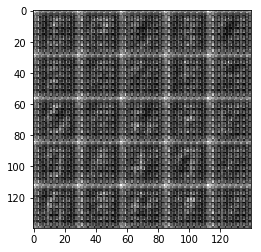

Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.4736
Epoch 1/2... Discriminator Loss: 1.1117... Generator Loss: 1.5062
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 2.2269


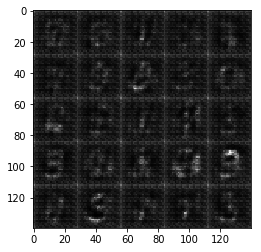

Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.2706
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.0550
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.2947


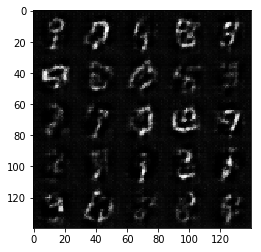

Epoch 1/2... Discriminator Loss: 1.5917... Generator Loss: 0.4308
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.0715
Epoch 1/2... Discriminator Loss: 1.6164... Generator Loss: 2.9247


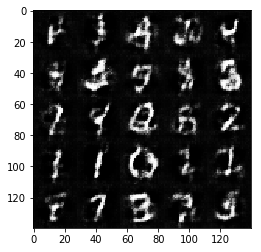

Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 1.5232
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 2.7621
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.2344
Epoch 1/2... Discriminator Loss: 1.3637... Generator Loss: 0.5526


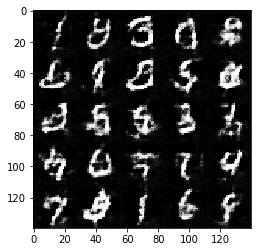

Epoch 1/2... Discriminator Loss: 1.0582... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.6285
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 0.9824
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.6299


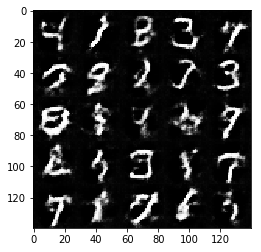

Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.0626... Generator Loss: 1.4612
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.5050


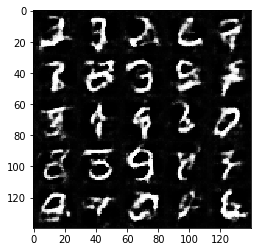

Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.6454


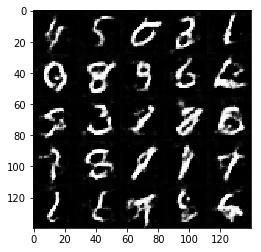

Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 0.7545
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 0.7559
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.5552
Epoch 1/2... Discriminator Loss: 1.0142... Generator Loss: 1.3245


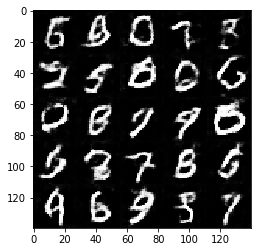

Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 1.1796
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 1.9357
Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 0.7320


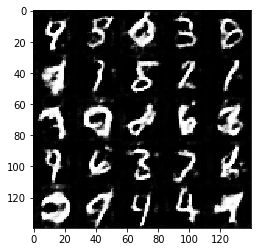

Epoch 1/2... Discriminator Loss: 0.8346... Generator Loss: 1.5992
Epoch 1/2... Discriminator Loss: 1.0648... Generator Loss: 0.8841
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.8835


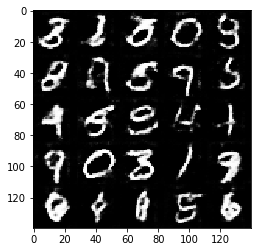

Epoch 1/2... Discriminator Loss: 0.9409... Generator Loss: 1.3704
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.0140
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.9069
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.2424


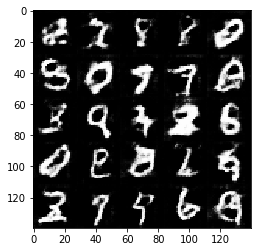

Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.3955
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.6900
Epoch 2/2... Discriminator Loss: 1.1251... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.0637... Generator Loss: 0.9603


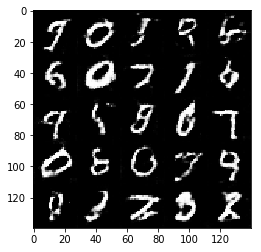

Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 0.9215
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 1.0846
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.6157


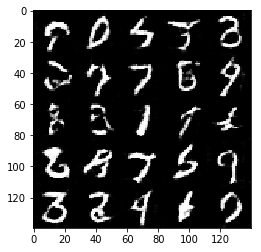

Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 1.5894
Epoch 2/2... Discriminator Loss: 2.1670... Generator Loss: 3.4330
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 1.1802


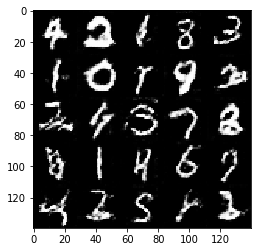

Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.5513
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.9103
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.8150


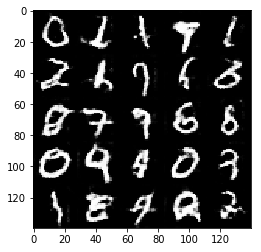

Epoch 2/2... Discriminator Loss: 0.7786... Generator Loss: 1.3543
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 2.2767
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.9350


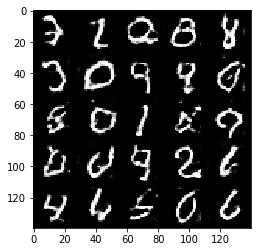

Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.2420
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.3607
Epoch 2/2... Discriminator Loss: 1.0772... Generator Loss: 0.7800


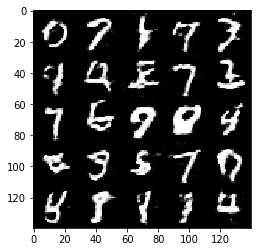

Epoch 2/2... Discriminator Loss: 0.8416... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 0.8776... Generator Loss: 1.1734
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.9617


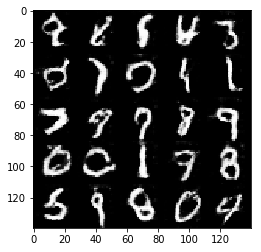

Epoch 2/2... Discriminator Loss: 1.3106... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.2913
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.0397


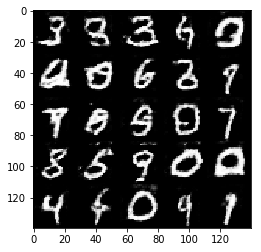

Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 2.1593
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 1.8728
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 0.9785


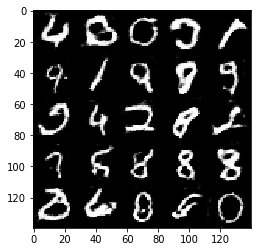

Epoch 2/2... Discriminator Loss: 0.7563... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 0.8316... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.1526


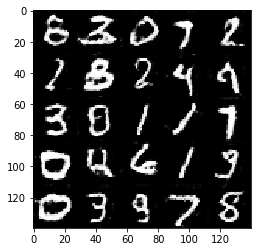

Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.0536
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.2813
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.6216... Generator Loss: 0.4153


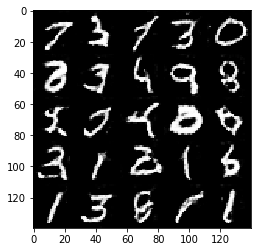

Epoch 2/2... Discriminator Loss: 2.1077... Generator Loss: 0.2652


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
#Epoch 2/2... Discriminator Loss: 0.4178... Generator Loss: 4.3547


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 2.0224
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 7.0806
Epoch 1/1... Discriminator Loss: 0.5028... Generator Loss: 2.8771
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.2593


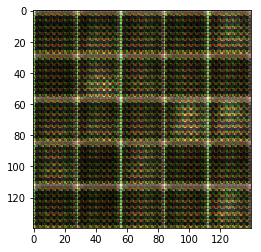

Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.1349
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8645


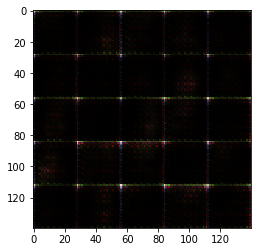

Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 2.1560
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.6335


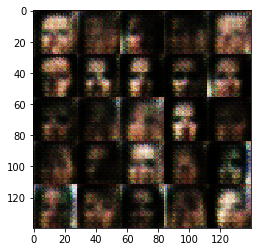

Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.8202


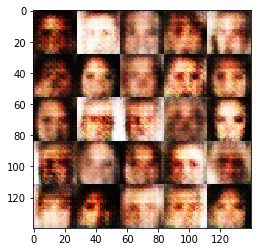

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 1.0458
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 1.0084
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8596


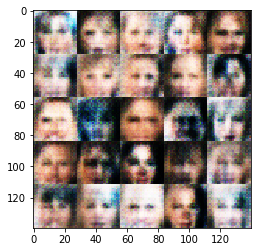

Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8155


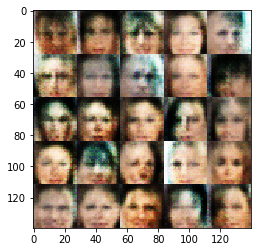

Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.8440


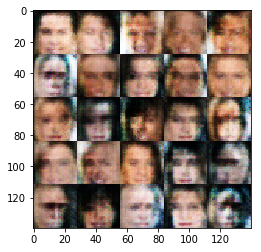

Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6830


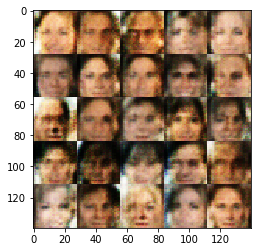

Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 1.2419
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 1.1281


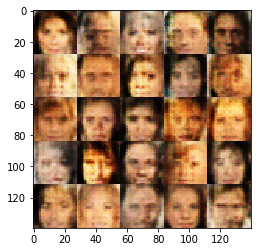

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.9546


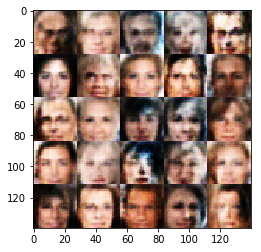

Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 1.0863
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1822
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.8153


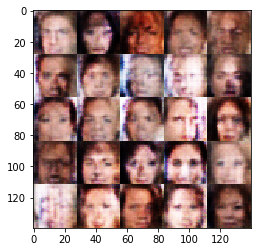

Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7360


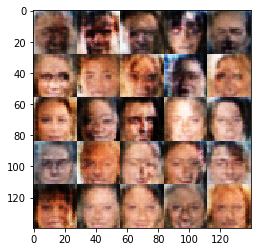

Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.6113


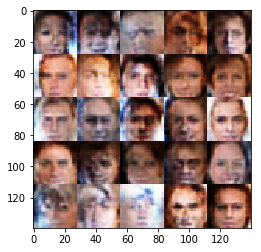

Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.0603


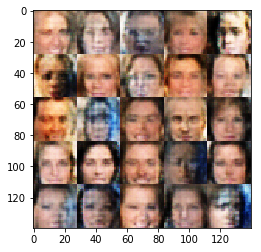

Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1515
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6651


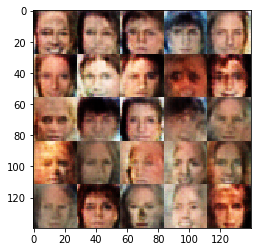

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.8944
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.8887


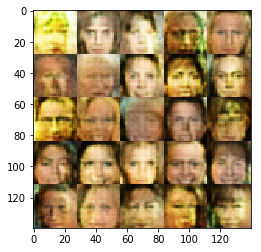

Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.8711


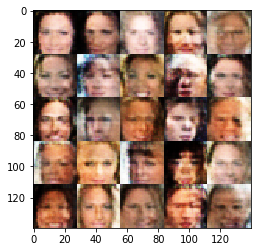

Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.1406
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5523


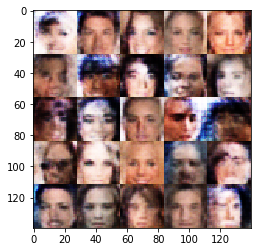

Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5987


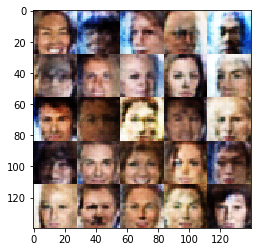

Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.9913


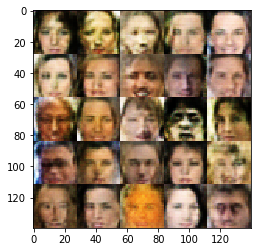

Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.0401


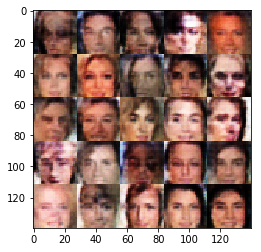

Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8530


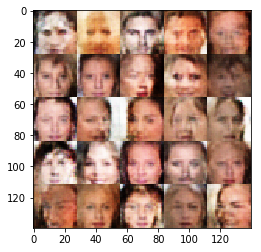

Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 1.4336
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8547


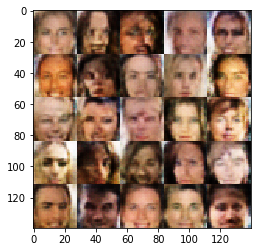

Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.2656
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1862
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.6361


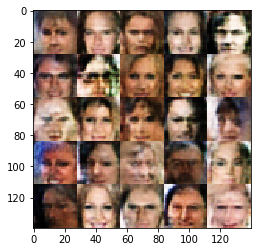

Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.6195


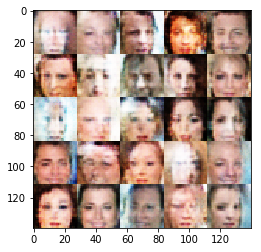

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.1112
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.8173


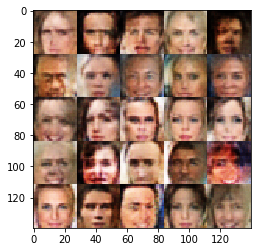

Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0285
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5279


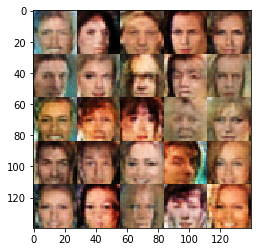

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 1.1378
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.1223


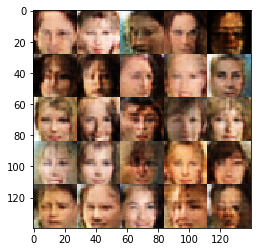

Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9078


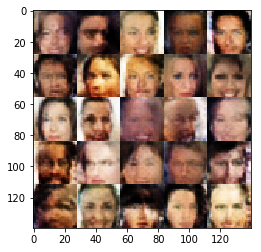

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.8935


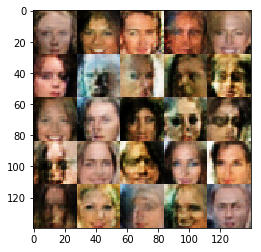

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.4414


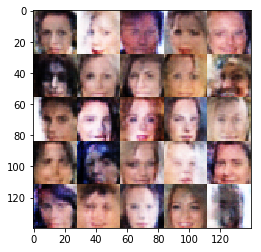

Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8545


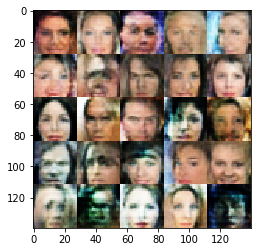

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8059
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.0129... Generator Loss: 0.9754


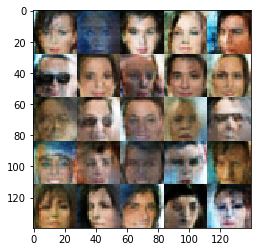

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.9664
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.7202


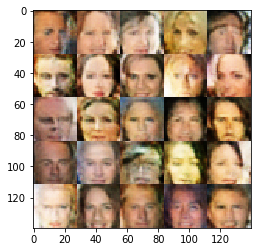

Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.4385
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7188


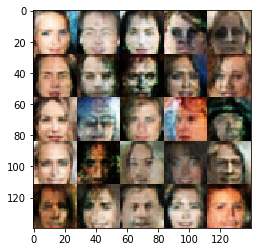

Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.8400


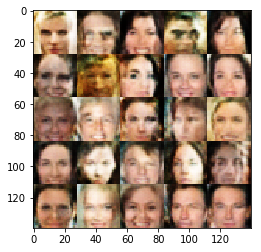

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.5108


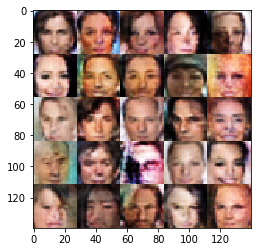

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.7841


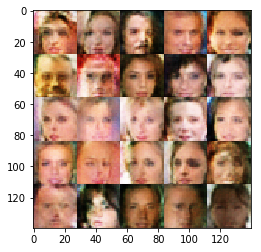

Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.1919


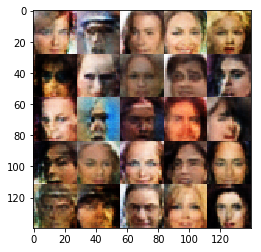

Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.0456... Generator Loss: 0.9902


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.